In [24]:
#Imporing libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

np.random.seed(1234)
torch.manual_seed(1234)

In [25]:
#Reading data
learn_data = pd.read_csv("bigml_59c28831336c6604c800002a.csv")
pd.options.display.max_columns = None
learn_data

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [26]:
#Defining columns
numerical_columns = ['number vmail messages', 'total day minutes', 'total day calls',
                     'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes',
                     'total night calls', 'total night charge', 'total intl minutes', 'total intl calls',
                     'total intl charge', 'customer service calls']
categorical_columns = ['state', 'international plan', 'voice mail plan','area code']
outputs = ['churn']

In [27]:
#Processing columns

#Numerical
numerical_data = np.stack([learn_data[col].values for col in numerical_columns], 1)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

#Categorical
for category in categorical_columns:
    learn_data[category] = learn_data[category].astype('category')
    
st = learn_data['state'].cat.codes.values
ip = learn_data['international plan'].cat.codes.values
vm = learn_data['voice mail plan'].cat.codes.values
ac = learn_data['area code'].cat.codes.values

categorical_data = np.stack([st, ip, vm, ac], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

#Outputs
learn_data[outputs] = learn_data[outputs].astype(int)

outputs = torch.tensor(learn_data[outputs].values).flatten()
outputs = outputs.long()

In [28]:
numerical_data.shape

torch.Size([3333, 14])

In [29]:
#Dividing the data
total_records = 3333
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

In [30]:
from torch.nn.parameter import Parameter
from torch.nn import init
import math

#Creating the Neural Network
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(14, 100)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(100)
        
        self.weights1 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights1, a=math.sqrt(5))
        
        self.weights2 = Parameter(torch.Tensor(1, 120))
        init.kaiming_uniform_(self.weights2, a=math.sqrt(5))
        
        self.bias1 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights1)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias1, -bound, bound)
        
        self.bias2 = Parameter(torch.Tensor(1))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weights2)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias2, -bound, bound)
        
        self.layer1_1 = nn.Embedding(51, 5)
        self.bn1_1 = nn.BatchNorm1d(5)
        self.layer1_2 = nn.Embedding(2, 5)
        self.bn1_2 = nn.BatchNorm1d(5)
        self.layer1_3 = nn.Embedding(2, 5)
        self.bn1_3 = nn.BatchNorm1d(5)
        self.layer1_4 = nn.Embedding(3, 5)
        self.bn1_4 = nn.BatchNorm1d(5)
        
        self.layer2 = nn.Linear(120, 120)
        self.bn2 = nn.BatchNorm1d(120)
        
    def forward(self, x_numerical, x_categorical):
        x1 = self.layer1(x_numerical)
        x1 = self.relu(x1)
        x1 = self.bn1(x1)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x1_embedding = self.relu(x1_embedding)
        x1_embedding = self.bn1_1(x1_embedding)
        
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x2_embedding = self.relu(x2_embedding)
        x2_embedding = self.bn1_2(x2_embedding)
        
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x3_embedding = self.relu(x3_embedding)
        x3_embedding = self.bn1_3(x3_embedding)
        
        x4_embedding = self.layer1_4(x_categorical[:,3])
        x4_embedding = self.relu(x4_embedding)
        x4_embedding = self.bn1_4(x4_embedding)
        
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding,x4_embedding], 1)
                
        x1 = torch.cat([x1, x_embedding], 1)
        
        x2 = self.layer2(x1)        
        emb = self.relu(x2)
        x2 = self.bn2(emb)
        
        x2_weights1 = torch.mm(x2, self.weights1.t()) + self.bias1
        x2_weights2 = torch.mm(x2, self.weights2.t()) + self.bias2
        
        x3 = torch.cat([x2_weights1, x2_weights2], 1)
                
        return emb, self.weights1, self.weights2, x3

In [31]:
model = Model()

In [47]:
#===============================================================================================
# Defining churn:loyal weight ratio. churn_percentage=0.7 means churn:loyal weight ratio of 7:3.
# Setting churn_percentage=0.5 to get an unweighted model
#===============================================================================================
churn_percentage = 0.7
model.load_state_dict(torch.load( "model_train_cre_{}.pth".format(churn_percentage)))

<All keys matched successfully>

In [48]:
model.eval()
with torch.no_grad():
    x1, w1, w2, x2 = model(numerical_test_data, categorical_test_data)

In [49]:
#Defining loss function
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
#Creating predictions
with torch.no_grad():
    test, test_weights1, test_weights2, test_embed = model(numerical_test_data, categorical_test_data)
    loss = loss_function(test_embed, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 1.16488695


In [51]:
from sklearn.metrics import f1_score

test_val = np.argmax(test_embed, axis=1)
print(confusion_matrix(test_outputs, test_val))
print(classification_report(test_outputs, test_val))
print("Accuracy: ", accuracy_score(test_outputs, test_val))
print("F1 Score: ", f1_score(test_outputs, test_val, average='macro'))

[[519  40]
 [ 31  78]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       559
           1       0.66      0.72      0.69       109

    accuracy                           0.89       668
   macro avg       0.80      0.82      0.81       668
weighted avg       0.90      0.89      0.90       668

Accuracy:  0.8937125748502994
F1 Score:  0.8116015142426998


In [52]:
test_data = learn_data[train_records+valid_records:total_records]
test_data = test_data.reset_index()

train_data = learn_data[0:train_records]
train_data = train_data.reset_index()

In [53]:
with torch.no_grad():
    x1, w1, w2, x2 = model(numerical_test_data, categorical_test_data)

In [54]:
embedding = x1.tolist()

In [55]:
x = embedding

In [41]:
tsne = TSNE(n_components=2, verbose=1, perplexity=600, n_iter=1000)
principalComponents = tsne.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

[t-SNE] Computing 667 nearest neighbors...
[t-SNE] Indexed 668 samples in 0.000s...
[t-SNE] Computed neighbors for 668 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 668 / 668
[t-SNE] Mean sigma: 6.230067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 32.163429
[t-SNE] KL divergence after 950 iterations: 0.022689


In [42]:
finalDf = pd.concat([principalDf, test_data[['churn']]], axis = 1)

finalDf0 = finalDf[finalDf['churn']==0]
finalDf1 = finalDf[finalDf['churn']==1]

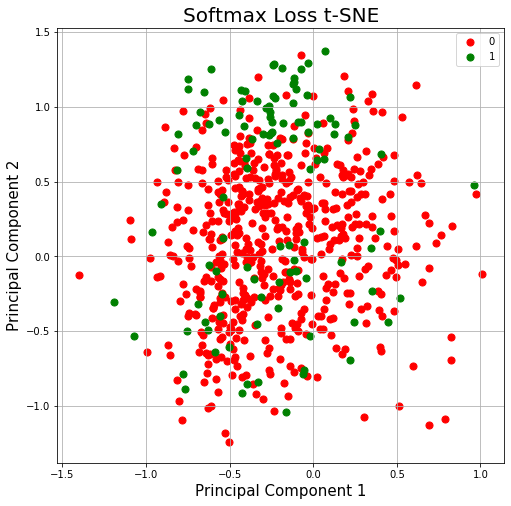

In [43]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Softmax Loss t-SNE', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['churn'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

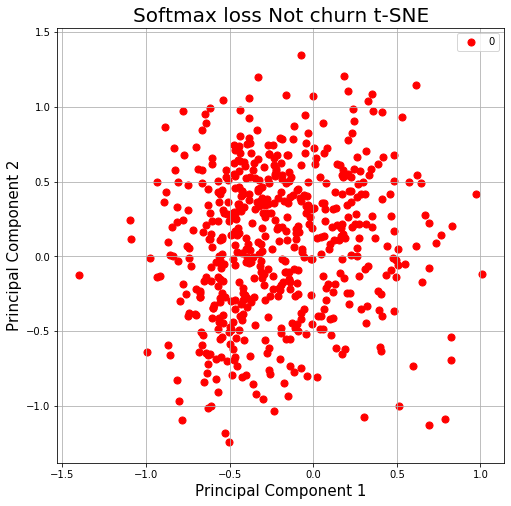

In [44]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Softmax loss Not churn t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0]
colors = ['r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf0['churn'] == target
    ax.scatter(finalDf0.loc[indicesToKeep, 'principal component 1']
               , finalDf0.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

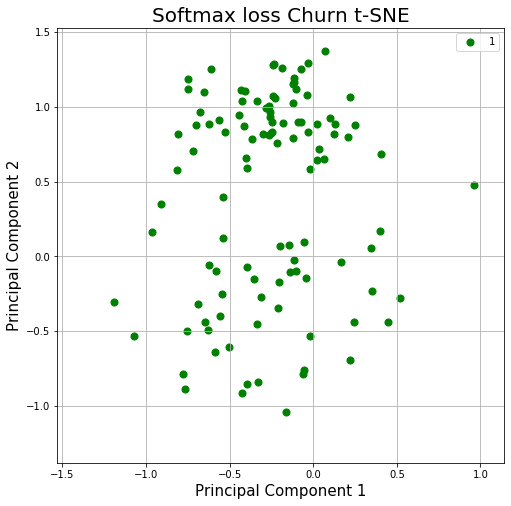

In [45]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Softmax loss Churn t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [1]
colors = ['g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf1['churn'] == target
    ax.scatter(finalDf1.loc[indicesToKeep, 'principal component 1']
               , finalDf1.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [56]:
notchurn_emb = x1[test_outputs==0]
sum_notchurn = x1[test_outputs==0].sum(dim=0)
center_notchurn = sum_notchurn/sum_notchurn.norm(p=2)
center_notchurn = center_notchurn.unsqueeze(0)

churn_emb = x1[test_outputs==1]
sum_churn = x1[test_outputs==1].sum(dim=0)
center_churn = sum_churn/sum_churn.norm(p=2)
center_churn = center_churn.unsqueeze(0)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

notchurn_centnotchurn_sim = cos(notchurn_emb, center_notchurn).mean()
notchurn_centchurn_sim = cos(notchurn_emb, center_churn).mean()
churn_centchurn_sim = cos(churn_emb, center_churn).mean()
churn_centnotchurn_sim = cos(churn_emb, center_notchurn).mean()

print("emb not churn, center not churn (not churn intra-cluster): ", notchurn_centnotchurn_sim)
print("emb not churn, center churn (not churn inter-cluster): ", notchurn_centchurn_sim)
print("emb churn, center churn (churn intra-cluster): ", churn_centchurn_sim)
print("emb churn, center not churn (churn inter-cluster): ", churn_centnotchurn_sim)

print("not churn inter-intra cluster ratio: ", notchurn_centnotchurn_sim/notchurn_centchurn_sim)
print("churn inter-intra cluster ratio: ", churn_centchurn_sim/churn_centnotchurn_sim)

emb not churn, center not churn (not churn intra-cluster):  tensor(0.5546)
emb not churn, center churn (not churn inter-cluster):  tensor(0.5327)
emb churn, center churn (churn intra-cluster):  tensor(0.6352)
emb churn, center not churn (churn inter-cluster):  tensor(0.5345)
not churn inter-intra cluster ratio:  tensor(1.0411)
churn inter-intra cluster ratio:  tensor(1.1883)
